In [49]:
'''read data'''

import pandas as pd
tweets_all = pd.read_csv('Raw tweets(No Just)_December27_11:25PM_CST_alldata.csv')
replies = pd.read_csv('Raw tweets(No Just)_December27_11:25PM_CST_Replies.csv')
retweets = pd.read_csv('Raw tweets(No Just)_December27_11:25PM_CST_Retweets.csv')
tweets_clean = pd.read_csv('Raw tweets(No Just)_December27_11:25PM_CST_NoReplies_NoRetweets.csv')
print('The number of tweets:',len(tweets_all['tweets']))
print('The number of replies:',len(replies['tweets']))
print('The number of retweets:',len(retweets['tweets']))
print('The number of clean tweets:',len(tweets_clean['tweets']))

The number of tweets: 7907
The number of replies: 1441
The number of retweets: 3251
The number of clean tweets: 3215


In [50]:
'''---------------------------------------------------------------------------------------
Text cleaning:remove @user, URLs, hashtags, non-alphabets characters and special characters (&amp)
保留lowercase，轉換為root form，去除長度小於4的單詞'''
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
import pandas as pd
text = tweets_clean
b = []
for i,u in text.iterrows():
    a = []
    word =''
    for words in str(u['tweets']).split():
        if '@' not in words: #remove @users
            #words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = words.lower()# lower form
                        words = re.sub(r'[^a-zA-Z]', ' ', words) #replace non-alphabets characters with space. From "can't" to "can t"
                        if len(words)>3:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if token not in stop_words:
            token = porter.stem(token) #root form
            doc += (token+' ')
    b.append(doc)
text['processed']=[i for i in b]



In [51]:
text['processed'].head(10)

0    unpreced time devot attent brighter futur cell...
1                     chat happen cellular agricultur 
2    climat chao climat transform proud name compan...
3    holiday feel littl differ year still excit fut...
4                      speak today iit virtual summit 
5    team commit perfect delici product last impact...
6    interest year thank commun support enthusiasm ...
7    winner best brightest compani work nation area...
8    want delici meat product help environ product ...
9    happi join intern associ food protect mission ...
Name: processed, dtype: object

In [52]:
'''---------------------------------------------------------------------------------------
生成bigram：基於gensim.model.phrase的方式'''

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #將句子變為token，生成list
data_words = list(sent_to_words(text['processed'])) #tokenization
bigram = gensim.models.Phrases(data_words,min_count=1,threshold=1)
'''mincount：兩個單詞共同出現次數小於該值，則不會被考慮為bigram，
threshold：Phrases功能中會生成一個'phase score'，超過這個score的bigram會生成在最終結果中，總的來說，mincount越小，threshold越小，最終生成的bigram越多'''
bigram_mod = gensim.models.phrases.Phraser(bigram) #生成bigram
def make_bigrams(texts): #生成bigram
    return [bigram[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

In [53]:
data_words_bigrams[:10]

[['unpreced_time',
  'devot',
  'attent',
  'brighter_futur',
  'cell_base',
  'meat',
  'bring',
  'peopl',
  'togeth',
  'around_dinner',
  'tabl',
  'proud',
  'team',
  'reflect',
  'last_year',
  'holiday',
  'parti_celebr',
  'commun'],
 ['chat', 'happen_cellular', 'agricultur'],
 ['climat',
  'chao',
  'climat',
  'transform',
  'proud_name',
  'compani',
  'recognit',
  'potenti',
  'tackl_climat',
  'crisi',
  'meaning',
  'measur',
  'solut'],
 ['holiday',
  'feel',
  'littl_differ',
  'year',
  'still',
  'excit',
  'futur',
  'part',
  'cozi',
  'famili',
  'meal',
  'would',
  'want',
  'cook',
  'holiday',
  'cell_base',
  'meat'],
 ['speak_today', 'iit', 'virtual_summit'],
 ['team_commit', 'perfect', 'delici_product', 'last_impact', 'gener'],
 ['interest',
  'year_thank',
  'commun',
  'support_enthusiasm',
  'encourag',
  'continu',
  'work_bring',
  'best',
  'tastiest',
  'product',
  'tabl',
  'grate',
  'opportun',
  'share_journey'],
 ['winner',
  'best',
  'bright

([<matplotlib.axis.XTick at 0x7fc1c54d4310>,
 <a list of 11 Text xticklabel objects>)

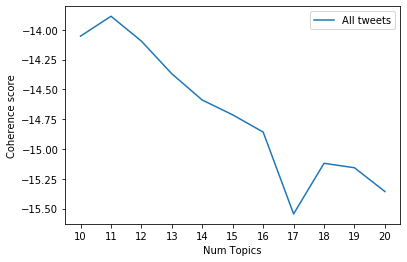

In [54]:
'''---------------------------------------------------------------------------------------
counting coherence score,使用的是u_mass'''

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=8)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))

In [55]:
'''---------------------------------------------------------------------------------------
print bigrams within each topic'''

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=11,random_state=8,alpha='auto',per_word_topics=True)
#pprint(lda_model.print_topics(num_words=400))
for idx, topic in lda_model.show_topics(formatted=False,num_topics=11,num_words= 1000):
    print('\n',end='')
    print('Topic:',idx)
    for w in topic:
        if '_' in w[0]:
            print(round(w[1],4),'*',w[0],', ',end='',sep='')



Topic: 0
0.0168*cell_base, 0.0079*aleph_farm, 0.0059*plant_base, 0.0054*world_first, 0.0046*altern_protein, 0.004*check_latest, 0.0035*isra_startup, 0.003*food_tech, 0.0025*seafood_product, 0.0023*cultur_meat, 0.0022*blog_post, 0.0021*clean_meat, 0.0021*slaughter_free, 0.0019*cultiv_meat, 0.0018*tast_like, 0.0017*make_sure, 0.0016*join_tomorrow, 0.0016*start_up, 0.0014*base_meat, 0.0014*work_hard, 0.0013*cellular_agricultur, 0.0012*thank_featur, 0.0012*first_ever, 0.0012*sushi_grade, 0.0011*look_like, 0.0011*talk_cell, 0.0011*food_futur, 0.0011*wild_salmon, 0.0011*hear_speak, 0.0011*cultur_fish, 0.0011*cruelti_free, 0.0011*pleas_announc, 0.0011*make_futur, 0.0011*five_year, 0.0011*thank_video, 0.0011*memphi_meat, 0.001*meat_industri, 0.0009*product_method, 0.0009*next_year, 0.0009*climat_chang, 0.0009*tradit_meat, 0.0008*last_week, 0.0008*futur_meat, 0.0008*thank_much, 0.0008*senior_manag, 0.0008*proud_part, 0.0008*food_scienc, 0.0008*excel_articl, 0.0007*sustain_food, 0.0007*real_mea

0.0124*clean_meat, 0.0028*cultur_meat, 0.0028*meat_industri, 0.002*excit_featur, 0.002*long_term, 0.002*proud_announc, 0.002*bring_product, 0.002*year_ago, 0.0019*sushi_grade, 0.0018*memphi_meat, 0.0015*cellular_agricultur, 0.0013*food_research, 0.0012*plant_base, 0.0011*along_amaz, 0.0011*game_chang, 0.0011*thing_past, 0.0011*everi_year, 0.0011*protein_sourc, 0.0011*meat_anim, 0.0011*mani_thing, 0.0011*food_technolog, 0.0011*peopl_passion, 0.0011*show_next, 0.0011*world_econom, 0.0011*honor_featur, 0.0011*make_differ, 0.0011*biggest_problem, 0.0011*sign_free, 0.0011*look_littl, 0.0011*food_wast, 0.0011*blown_away, 0.0011*world_right, 0.0011*startup_manual, 0.0011*come_soon, 0.0011*articl_outlin, 0.0011*creativ_solut, 0.0011*sustain_summit, 0.0011*time_join, 0.0011*product_peopl, 0.0011*sound_good, 0.0011*market_check, 0.0011*get_readi, 0.0011*amaz_team, 0.001*amino_acid, 0.001*cell_base, 0.0009*pork_sausag, 0.0009*pleas_appli, 0.0008*meat_without, 0.0008*excel_articl, 0.0007*finless_f

0.0056*base_meat, 0.0047*cell_base, 0.0046*cultiv_meat, 0.0038*make_cell, 0.0032*chief_scientif, 0.0027*delici_sustain, 0.0026*last_week, 0.0025*cultur_meat, 0.0021*work_togeth, 0.0019*co_founder, 0.0019*listen_talk, 0.0019*food_futur, 0.0019*industri_cell, 0.0019*huge_step, 0.0019*speak_futur, 0.0019*scale_product, 0.0019*meat_anim, 0.0019*registr_free, 0.0019*success_stori, 0.0019*cell_line, 0.0018*world_need, 0.0017*futur_food, 0.0016*clean_meat, 0.0015*congrat_friend, 0.0014*cell_cultur, 0.0013*futur_meat, 0.0012*meat_produc, 0.0011*join_next, 0.0011*regen_medicin, 0.0011*februari_th, 0.0011*delici_meat, 0.0011*young_innov, 0.0011*summit_francisco, 0.0011*hope_enjoy, 0.0011*ever_cultur, 0.0011*thank_explain, 0.0011*way_thank, 0.0011*scienc_busi, 0.0011*technolog_regul, 0.0011*protein_product, 0.0011*rethink_food, 0.0011*took_part, 0.0011*meat_market, 0.0011*love_come, 0.0011*anim_feed, 0.0011*thank_happi, 0.0011*watch_close, 0.0011*protein_pack, 0.0011*impact_ventur, 0.0011*introdu

0.0036*look_forward, 0.0035*break_news, 0.0031*co_founder, 0.0027*stem_cell, 0.0025*answer_question, 0.0025*anim_product, 0.0022*altern_protein, 0.0022*free_time, 0.0021*bring_cultiv, 0.0019*clean_meat, 0.0018*futur_meat, 0.0018*sustain_food, 0.0017*leadership_team, 0.0017*st_centuri, 0.0017*cell_base, 0.0017*look_like, 0.0017*wild_caught, 0.0017*help_save, 0.0017*would_make, 0.0016*meat_want, 0.0014*cell_biolog, 0.0014*memphi_meat, 0.0012*convent_fish, 0.0012*hard_work, 0.0012*honor_includ, 0.0011*thank_much, 0.0011*lab_grown, 0.0011*food_industri, 0.001*free_meat, 0.001*know_peopl, 0.001*lead_investor, 0.001*support_mission, 0.001*work_friend, 0.001*solv_biggest, 0.001*use_tool, 0.001*industri_farm, 0.001*scale_product, 0.001*cost_product, 0.001*grown_meat, 0.001*want_join, 0.001*compani_work, 0.001*spread_word, 0.001*eat_habit, 0.001*need_increas, 0.001*want_make, 0.001*mani_year, 0.001*great_month, 0.001*pleas_check, 0.001*need_altern, 0.001*meat_directli, 0.001*agricultur_land, 0.

0.0065*co_founder, 0.005*plant_base, 0.0048*lab_grown, 0.0039*cellular_agricultur, 0.0039*global_food, 0.0035*gt_gt, 0.0034*thank_featur, 0.0032*look_forward, 0.0029*clean_seafood, 0.0026*suppli_chain, 0.0025*stem_cell, 0.0024*thank_invit, 0.0022*cell_base, 0.0022*sourc_food, 0.0022*anim_health, 0.0022*product_develop, 0.0019*chief_scientif, 0.0018*clean_meat, 0.0017*meat_product, 0.0017*octob_th, 0.0016*futur_food, 0.0016*convent_meat, 0.0015*next_week, 0.0015*tech_compani, 0.0015*click_link, 0.0015*innov_sustain, 0.0015*go_market, 0.0015*read_stori, 0.0015*cultur_meat, 0.0015*climat_chang, 0.0015*muscl_cell, 0.0014*meat_industri, 0.0014*produc_meat, 0.0012*meat_consumpt, 0.0012*without_anim, 0.0011*food_tech, 0.001*thank_much, 0.001*world_eat, 0.001*base_meat, 0.0009*altern_protein, 0.0009*food_system, 0.0009*mark_post, 0.0009*anim_cell, 0.0009*develop_goal, 0.0009*thank_celebr, 0.0009*sustain_produc, 0.0009*game_chang, 0.0009*offic_prof, 0.0009*excit_among, 0.0009*small_amount, 0.00

0.0147*cell_base, 0.0051*altern_protein, 0.004*cultur_meat, 0.0039*food_thought, 0.0037*futur_food, 0.0033*aleph_farm, 0.0033*rais_million, 0.0031*cultiv_meat, 0.0026*memphi_meat, 0.0021*innov_food, 0.0021*team_grow, 0.0021*larg_scale, 0.0021*next_gener, 0.0021*healthi_safe, 0.0017*clean_meat, 0.0016*cellular_agricultur, 0.0016*meat_made, 0.0016*healthi_sustain, 0.0015*cell_cultur, 0.0014*food_suppli, 0.0014*follow_link, 0.0014*check_interview, 0.0014*tast_futur, 0.0014*product_facil, 0.0014*healthier_world, 0.0014*proud_featur, 0.0012*around_world, 0.0012*happi_announc, 0.0012*base_meat, 0.0012*food_scienc, 0.0012*feed_billion, 0.001*food_system, 0.001*convent_meat, 0.001*meat_product, 0.001*food_beverag, 0.001*discuss_futur, 0.001*help_solv, 0.001*futur_meat, 0.0009*replac_anim, 0.0008*thank_shoutout, 0.0008*aim_bring, 0.0008*product_consum, 0.0008*billion_dollar, 0.0008*eat_clean, 0.0008*head_like, 0.0008*kill_anim, 0.0008*avail_plant, 0.0008*invit_give, 0.0008*thank_featur, 0.0008*

0.0074*co_founder, 0.0044*cell_base, 0.0042*chang_world, 0.0041*thank_cover, 0.0041*futur_field, 0.0037*meat_without, 0.0026*across_globe, 0.0025*clean_meat, 0.0024*food_product, 0.002*anim_cruelti, 0.0019*cultiv_meat, 0.0018*make_sure, 0.0018*poultri_seafood, 0.0018*anim_free, 0.0018*futur_seafood, 0.0018*check_articl, 0.0018*great_talk, 0.0018*world_class, 0.0016*cultur_meat, 0.0015*meat_produc, 0.0015*good_food, 0.0014*stem_cell, 0.0014*better_futur, 0.0013*cellular_agricultur, 0.0012*harm_anim, 0.0012*memphi_meat, 0.0012*slaughter_anim, 0.0012*good_news, 0.0011*lab_grown, 0.0011*cell_cultur, 0.001*take_look, 0.001*dutch_breakthrough, 0.001*benefit_peopl, 0.001*reduc_plastic, 0.001*anim_environ, 0.001*make_meat, 0.001*food_industri, 0.001*team_look, 0.001*advoc_cell, 0.001*find_way, 0.001*last_coupl, 0.001*thank_explor, 0.001*first_time, 0.001*name_isra, 0.001*save_world, 0.001*anim_welfar, 0.001*founder_ceo, 0.001*closer_think, 0.001*excerpt_book, 0.001*also_mercuri, 0.001*want_mak

0.0039*world_first, 0.0037*produc_real, 0.0037*clean_meat, 0.0029*choic_make, 0.0029*check_know, 0.0028*excit_share, 0.0028*co_founder, 0.0025*real_meat, 0.0025*excit_announc, 0.0024*cultur_meat, 0.0023*seafood_product, 0.0022*without_harm, 0.002*feed_planet, 0.002*singl_cell, 0.002*board_member, 0.002*click_link, 0.002*thank_help, 0.002*last_impact, 0.002*part_panel, 0.002*import_develop, 0.002*thank_highlight, 0.002*look_forward, 0.0018*memphi_meat, 0.0016*meat_eat, 0.0015*suppli_chain, 0.0014*around_world, 0.0014*make_real, 0.0014*make_histori, 0.0013*meat_without, 0.0013*chang_world, 0.0013*climat_chang, 0.0011*plant_base, 0.0011*address_climat, 0.0011*world_without, 0.0011*launch_websit, 0.0011*firesid_chat, 0.0011*ceo_featur, 0.0011*promis_innov, 0.0011*speak_futur, 0.0011*mission_bring, 0.0011*want_chang, 0.0011*proud_share, 0.0011*past_week, 0.0011*meat_plant, 0.0011*growth_medium, 0.0011*meat_demand, 0.0011*rais_slaughter, 0.0011*june_stockholm, 0.0011*real_delici, 0.0011*awar

0.0042*team_member, 0.003*meat_futur, 0.0028*cell_base, 0.0028*clean_meat, 0.0026*must_read, 0.0026*chang_world, 0.0026*memphi_meat, 0.0023*grow_team, 0.0022*step_closer, 0.0021*feed_billion, 0.002*cell_cultur, 0.0018*peopl_anim, 0.0018*today_announc, 0.0018*excit_speak, 0.0018*tune_learn, 0.0018*healthi_clean, 0.0018*last_month, 0.0018*summit_today, 0.0018*futur_product, 0.0017*make_meat, 0.0017*join_team, 0.0017*co_founder, 0.0016*healthi_sustain, 0.0016*excit_announc, 0.0015*great_coverag, 0.0015*look_forward, 0.0013*food_revolut, 0.0012*environment_impact, 0.0012*futur_gener, 0.0012*reinvent_meat, 0.0012*cell_anim, 0.0011*love_meat, 0.001*happi_year, 0.001*thank_support, 0.001*delight_ceo, 0.001*thrill_join, 0.001*world_lead, 0.001*event_focus, 0.001*join_research, 0.001*futur_protein, 0.001*market_intern, 0.001*environment_friendli, 0.001*behind_scene, 0.001*talk_futur, 0.001*scale_cultur, 0.001*spent_talk, 0.001*thank_organ, 0.001*drive_forc, 0.001*bring_clean, 0.001*sustain_feed

In [56]:
'''---------------------------------------------------------------------------------------
output LDA，生成一個包含dominant topic，keywords，probability of the topic的csv文件
並通過這個文件，統計各個主題內tweets的數量'''

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text['tweets'])
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.to_csv('dominant topics(NOJust)_December_27_11:25PM_CST_data.csv')
data = pd.read_csv('dominant topics(NOJust)_December_27_11:25PM_CST_data.csv')
# tweets count
print('\n')
print('Number of Tweets within each topic:',data.groupby('Dominant_Topic')['Text'].count())



Number of Tweets within each topic: Dominant_Topic
0.0     602
1.0     260
2.0     234
3.0     260
4.0     322
5.0     308
6.0     245
7.0     287
8.0     229
9.0     192
10.0    276
Name: Text, dtype: int64


In [57]:
table1  = pd.read_excel('Table 1,2,3 December 27.xlsx',sheet_name=0)
table2 = pd.read_excel('Table 1,2,3 December 27.xlsx',sheet_name=1)
table3  = pd.read_excel('Table 1,2,3 December 27.xlsx',sheet_name=2)

In [58]:
table1

,Topic,Bigrams within topics,Number of tweets
0,1,"clean meat, israeli startup, breaking news, fu...",454
1,2,"co-founder, chief scientific, future field, ce...",388
2,3,"thank share, world first, cell-based, cellular...",364
3,4,"meat industry, blog post, grow team, answer qu...",389
4,5,"global food, across globe, cell biology, witho...",414
5,6,"supply chain, great talk, feed billion, cellul...",337
6,7,"slaughter free, poultry seafood, meat poultry,...",335
7,8,"CEO speak, United Nation, driving force, trans...",742
8,9,"taste like, check interview, seafood product, ...",423
9,10,"hank share, large scale, across country, slaug...",314


In [59]:
table2

,Theme,Bigrams within topics
0,Environmental Impact,climate change
1,NaN,greenhouse emission
2,NaN,"reduce plastic, coastal cleanup, address climate"
3,NaN,save ocean
4,NaN,environmental impact
...,...,...
81,NaN,plant-based
82,NaN,delicious plant
83,Announcement,pleased announce
84,NaN,happy announce


In [60]:
table3

,Theme,Tweets samples,Tweet link
0,Climate change,"In honor of #EarthDay2020, we are challenging ...",https://twitter.com/BlueNaluInc/status/1252764...
1,NaN,.@FastCompany reports on the announcement from...,https://twitter.com/AlephFarms/status/12731840...
2,NaN,"""One piece of advice can help you survive soci...",https://twitter.com/AlephFarms/status/12456080...
3,Different names of cultured meat,Achieving the perfect look and taste of our ce...,https://twitter.com/MemphisMeats/status/131677...
4,NaN,"Wait, did Robert Downey Jr just feature our me...",https://twitter.com/mosa_meat/status/133834347...
5,NaN,What's your main reason to support the transit...,https://twitter.com/mosa_meat/status/975010825...
6,seafood,Approximately 3 billion people in the world re...,https://twitter.com/FinlessFoods/status/110012...
7,NaN,We believe there's a better way to enjoy the s...,https://twitter.com/BlueNaluInc/status/1248764...
8,NaN,"""With its significant Series A complete, BlueN...",https://twitter.com/BlueNaluInc/status/1232814...
9,Poultry,"""According to a white paper by @GoodFoodInst, ...",https://twitter.com/BlueNaluInc/status/1169004...


In [61]:
'''---------------------------------------------------------------------------------------
統計Top 20 'hashtags，通過date parameter，以及drop.duplicates()，除去重複的'hashtag，
也就是說，如果同一個'hashtag在一篇tweet中出現兩次或以上，則只被計算一次'''

import pandas as pd
import numpy as np
import collections
data= pd.read_csv('Raw tweets(No Just)_December27_11:25PM_CST_NoReplies_NoRetweets.csv')
hashtag = []
date = []
for index,i in data.iterrows():
    for word in i['tweets'].split():
        if word.startswith('#'):
            date.append(i['date'])
            hashtag.append(word)
hashtag_trend = pd.DataFrame(data=hashtag,columns=['#'])
hashtag_trend['date'] = np.array(date)
data.drop_duplicates()
counts = collections.Counter(hashtag)
print('\n')
print('Top 20 hasgtags:',counts.most_common(20))



Top 20 hasgtags: [('#cleanmeat', 150), ('#culturedmeat', 122), ('#cultivatedmeat', 55), ('#ShiokMeats', 49), ('#meat', 36), ('#cellbasedmeat', 32), ('#FutureOfFood', 32), ('#Asia', 31), ('#cellularagriculture', 29), ('#cellbased', 27), ('#CleanMeat', 25), ('#Singapore', 25), ('#foodtech', 22), ('#SuperMeat', 21), ('#supermeat', 20), ('#CulturedMeat', 20), ('#sustainable', 19), ('#Startup', 19), ('#futureoffood', 18), ('#MeetTheTeam', 18)]


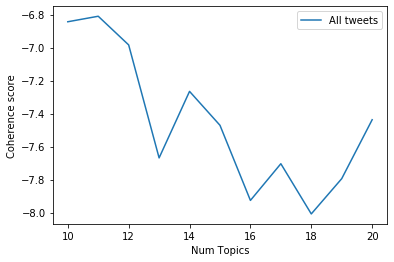

In [62]:
#unigram
unigram = []
unigram_list = []
for index, i in text.iterrows():
    unigram=[]
    for word in i['processed'].split():
        unigram.append(word)
    unigram_list.append(unigram)
data_words = [i for i in unigram_list]
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
#coherence score
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
# Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='All tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')

In [63]:
from pprint import pprint
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=11, random_state=2,
                                            alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics(num_words=50))

[(0,
  '0.018*"world" + 0.014*"gt" + 0.012*"chang" + 0.010*"congratul" + '
  '0.010*"next" + 0.009*"year" + 0.008*"good" + 0.007*"join" + 0.007*"human" + '
  '0.007*"team" + 0.007*"honor" + 0.007*"anim" + 0.007*"natur" + 0.007*"feed" '
  '+ 0.007*"food" + 0.007*"nice" + 0.006*"celebr" + 0.006*"meat" + '
  '0.005*"time" + 0.005*"happen" + 0.005*"much" + 0.005*"help" + '
  '0.005*"agricultur" + 0.005*"thank" + 0.005*"never" + 0.005*"today" + '
  '0.005*"first" + 0.004*"later" + 0.004*"award" + 0.004*"know" + 0.004*"book" '
  '+ 0.004*"farm" + 0.004*"marin" + 0.004*"must" + 0.004*"look" + '
  '0.004*"thought" + 0.004*"leader" + 0.004*"work" + 0.004*"l" + '
  '0.004*"cannot" + 0.004*"mainstream" + 0.004*"cohort" + 0.004*"medic" + '
  '0.004*"overcom" + 0.004*"promot" + 0.004*"second" + 0.004*"sustain" + '
  '0.004*"virtual" + 0.004*"talk" + 0.004*"climat"'),
 (1,
  '0.021*"food" + 0.020*"futur" + 0.016*"year" + 0.012*"finalist" + '
  '0.011*"thank" + 0.010*"excit" + 0.010*"strateg" + 0.009